<a href="https://colab.research.google.com/github/sai-teja-ponugoti/Face-Mask-Detection/blob/main/dev%20jupyter%20notebooks/dev_train_mask_detctor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# dataset is stored in google drive, so mounting the drive
from google.colab import drive
drive.mount('/content/drive')
!ls /content/drive/MyDrive/dataset

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
with_mask  without_mask


In [2]:
# import the required packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imutils import paths

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [3]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
TRAIN_DATA_DIR = "/content/drive/MyDrive/dataset"
IMG_HEIGHT = IMG_WIDTH = 224
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
EPOCHS = 10

In [4]:
# creating a ImageDataGenerator object to perform data agumentation and load data
train_datagen = ImageDataGenerator(rescale=1./255, 
    rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest",
    validation_split=0.1) # set validation split

# traing data generator, using flow from directory to create train set directly 
#from the data folders
train_generator = train_datagen.flow_from_directory(
    TRAIN_DATA_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training') # set as training data

# validation data generator, using flow from directory to create train set directly 
#from the data folders, reamining files after forming train set
validation_generator = train_datagen.flow_from_directory(
    TRAIN_DATA_DIR, # same directory as training data
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation') # set as validation data


Found 3451 images belonging to 2 classes.
Found 382 images belonging to 2 classes.


In [5]:
# load the MobileNetV2 network, ensuring the head FC layer sets are left off
#loading the model with weights obtained by traning on imagenet, 
# using transfer learning
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the base model
# can be designed according to the application needed
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model, 
#the combined model is the actual model that we need to train 
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

# compile the model
print("[INFO] compiling model...")
opt = Adam(lr=LEARNING_RATE, decay=LEARNING_RATE / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


In [6]:
# training the model
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // BATCH_SIZE,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // BATCH_SIZE,
    epochs = EPOCHS)

Epoch 1/10
 16/107 [===>..........................] - ETA: 35s - loss: 0.9752 - accuracy: 0.5039

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


107/107 [==============================] - 53s 496ms/step - loss: 0.4163 - accuracy: 0.8108 - val_loss: 0.1384 - val_accuracy: 0.9517
Epoch 2/10
107/107 [==============================] - 52s 488ms/step - loss: 0.1324 - accuracy: 0.9541 - val_loss: 0.0749 - val_accuracy: 0.9716
Epoch 3/10
107/107 [==============================] - 52s 486ms/step - loss: 0.0923 - accuracy: 0.9699 - val_loss: 0.0811 - val_accuracy: 0.9716
Epoch 4/10
107/107 [==============================] - 52s 488ms/step - loss: 0.0835 - accuracy: 0.9713 - val_loss: 0.0807 - val_accuracy: 0.9688
Epoch 5/10
107/107 [==============================] - 52s 491ms/step - loss: 0.0663 - accuracy: 0.9748 - val_loss: 0.0436 - val_accuracy: 0.9915
Epoch 6/10
107/107 [==============================] - 52s 490ms/step - loss: 0.0654 - accuracy: 0.9789 - val_loss: 0.0591 - val_accuracy: 0.9886
Epoch 7/10
107/107 [==============================] - 52s 485ms/step - loss: 0.0548 - accuracy: 0.9822 - val_loss: 0.0412 - val_accuracy: 0.9

[INFO] saving the mask detector model...


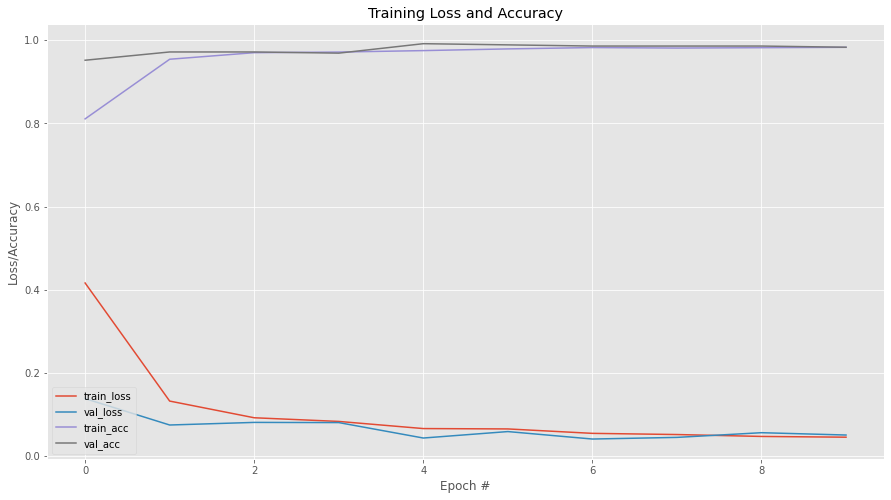

In [7]:
# saving the model to disk , so that it can be used later for prediction
print("[INFO] saving the mask detector model...")
model.save("mask_detector.model", save_format="h5")

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure(figsize=(15,8))
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

#code for prediction

In [10]:
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if np.argmax(classes):
      print("without mask")
  else:
      print("with mask")

#   print(np.argmax(classes))

Saving pic2.jpg to pic2 (1).jpg
[0.5433454  0.45665467]
with mask
